In [2]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

import os
from itertools import cycle
from functools import partial
import random
from math import pi
import json
from copy import deepcopy

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import networkx as nx

# Imports for working with shapefiles
import pyproj
from shapely.geometry import shape, MultiPolygon, mapping
from shapely.ops import transform, cascaded_union
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.colors import to_rgb
from matplotlib import cm
from matplotlib.patches import Polygon
%matplotlib inline

In [3]:
wisc_census_blocks = 'data/block_groups/shapes/tl_2013_55_bg.shp'

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

In [4]:
poptot_df = pd.read_csv('data/block_groups/pop_tot/DEC_10_SF1_P1_with_ann.csv')
poptot_df = poptot_df[['GEO.id2', 'D001']]
poptot_df.columns = ['geoid', 'poptot']
poptot_df.drop(0, axis=0, inplace=True)
poptot_df.set_index('geoid', inplace=True)

pop18_df = pd.read_csv('data/block_groups/pop18/DEC_10_SF1_P10_with_ann.csv')
pop18_df = pop18_df[['GEO.id2', 'D001', 'D003']]
pop18_df.columns = ['geoid', 'pop18', 'pop18wht']
pop18_df.drop(0, axis=0, inplace=True)
pop18_df.set_index('geoid', inplace=True)

In [5]:
with fiona.open(wisc_census_blocks) as f:
    blocks = [
        {
            'shape': transform(project, shape(block['geometry'])), 
            'geoid': block['properties']['GEOID'],
            'untransformed': shape(block['geometry'])
        }
        for block in f
    ]

In [6]:
for block in blocks:
    block['centroid'] = np.array([coord[0] for coord in block['shape'].centroid.xy])
    block['pop18'] = int(pop18_df.loc[block['geoid']]['pop18'])
    block['pop18wht'] = int(pop18_df.loc[block['geoid']]['pop18wht'])
    block['poptot'] = int(poptot_df.loc[block['geoid']]['poptot'])

In [7]:
coord_array = np.array([block['centroid'] for block in blocks])
weight_array = np.array([block['poptot'] for block in blocks])

In [8]:
model = KMeans(n_clusters=8, max_iter=1e6, n_jobs=-1, tol=1e-11)

In [9]:
labels = model.fit_predict(coord_array)

In [11]:
for label, block in zip(labels, blocks):
    block['label'] = int(label)

In [12]:
districts = [{} for i in range(8)]
for label in range(8):
    districts[label]['shape'] = cascaded_union([block['shape'] for block in blocks if block['label'] == label])
    
    districts[label]['untransformed'] = cascaded_union([
        block['untransformed']
        for block in blocks
        if block['label'] == label
    ])

In [13]:
wisc_pop = np.sum([block['poptot'] for block in blocks])
ideal_dist_pop = wisc_pop/8

for label in range(8):
    _tot_pop = np.sum([block['poptot'] for block in blocks if block['label'] == label])
    districts[label]['poptot'] = _tot_pop
    
    _tot_pop18 = np.sum([block['pop18'] for block in blocks if block['label'] == label])
    districts[label]['pop18'] = _tot_pop18
    
    _tot_pop18wht = np.sum([block['pop18wht'] for block in blocks if block['label'] == label])
    districts[label]['pop18wht'] = _tot_pop18wht
    
    _area = districts[label]['shape'].area/(1000)**2
    _perimeter = districts[label]['shape'].length/1000
    districts[label]['compactness'] = (4*pi*_area/_perimeter**2)
    
    _pop_diff = _tot_pop - ideal_dist_pop
    districts[label]['popdiff'] = _pop_diff/ideal_dist_pop
    
print(ideal_dist_pop, _tot_pop)

710873.25 472572


In [14]:
with fiona.open('data/districts/congressional/Wisconsin_Congressional_Districts.shp') as f:
    wisconsin = cascaded_union([transform(project, shape(district['geometry'])) for district in f])
    wisc_untrans = cascaded_union([shape(district['geometry']) for district in f])

In [15]:
wisc_untrans.bounds

(-92.8894329062527, 42.49191474914349, -86.76398658736599, 47.08077430717272)

In [16]:
def generate_colors(values, cmap, reference=1):
    _colors = [cmap(value/reference) for value in values]
    
    return _colors

In [17]:
def plot_shapes(
        shapelist, shape_colors, alpha=0.85, fig_file=None,
        center_of_mass_arr=None):
    _patches = [
        PolygonPatch(shape['shape'].intersection(wisconsin))
        for shape in shapelist
    ]
    
    for patch, color in zip(_patches, cycle(shape_colors)):
        patch.set_facecolor(color)
        patch.set_linewidth(1.5)
        patch.set_alpha(alpha)
        
    fig, ax = plt.subplots()
    
    fig.patch.set_alpha(0.0)

    for patch in _patches:
        ax.add_patch(patch)
        
    if center_of_mass_arr is not None:
        ax.plot(center_of_mass_arr[:,0], center_of_mass_arr[:,1])

    ax.relim()
    ax.autoscale_view()
    ax.axis('off')
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    aspect_ratio = (ymax - ymin)/(xmax - xmin)
    x_size = 20
    fig.set_size_inches((x_size, x_size*aspect_ratio))
    
    if fig_file:
        try:
            fig.savefig(fig_file, bbox_inches='tight')
        except IOError as e:
            raise(e)
            
    return None

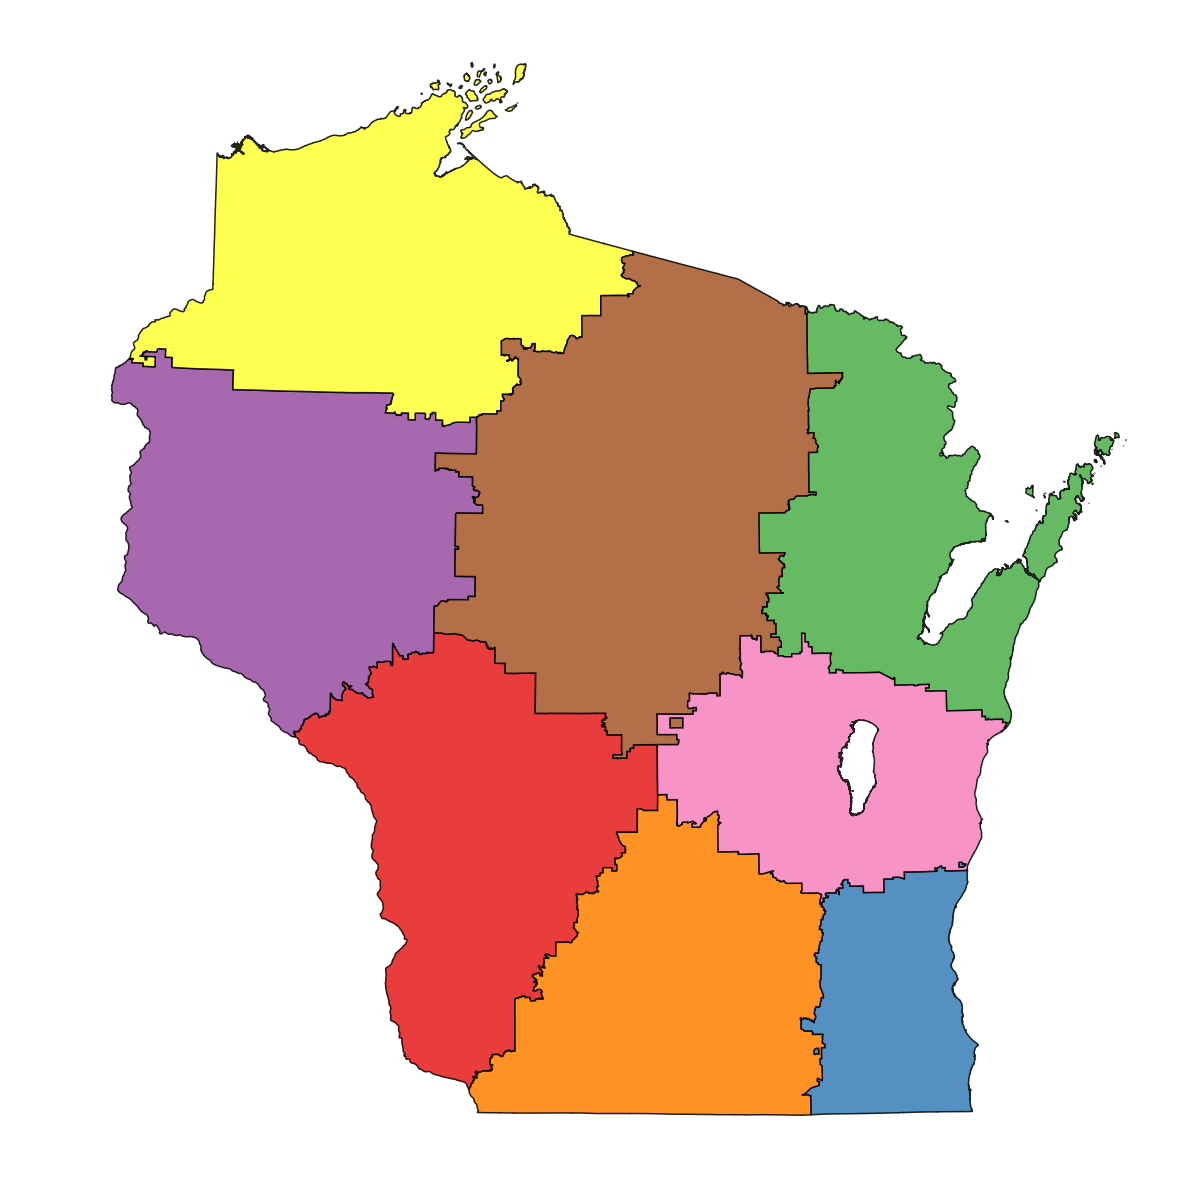

In [32]:
hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf'
]
district_colors = [to_rgb(color) for color in hex_colors]

kmeans_file = 'images/naive_kmeans_districts.png'
plot_shapes(districts, district_colors, fig_file=kmeans_file)

In [20]:
crs = from_epsg(4326)
schema = {
    'geometry': 'Polygon',
    'properties': {
        'id': 'int', 'cmpctness': 'float', 'poptot': 'int',
        'pop18': 'int', 'pop18wht': 'int', 'popdiff': 'float'
    }
}
with fiona.open('data/districts/generated/kmeans', 'w', 'ESRI Shapefile', schema, crs=crs) as c:
    for i, district in enumerate(districts):
            c.write({
                'geometry': mapping(district['untransformed'].intersection(wisc_untrans)),
                'properties': {
                    'id': i+1, 
                    'cmpctness': district['compactness'],
                    'poptot': district['poptot'],
                    'pop18': district['pop18'],
                    'pop18wht': district['pop18wht'],
                    'popdiff': district['popdiff']
                }
            })

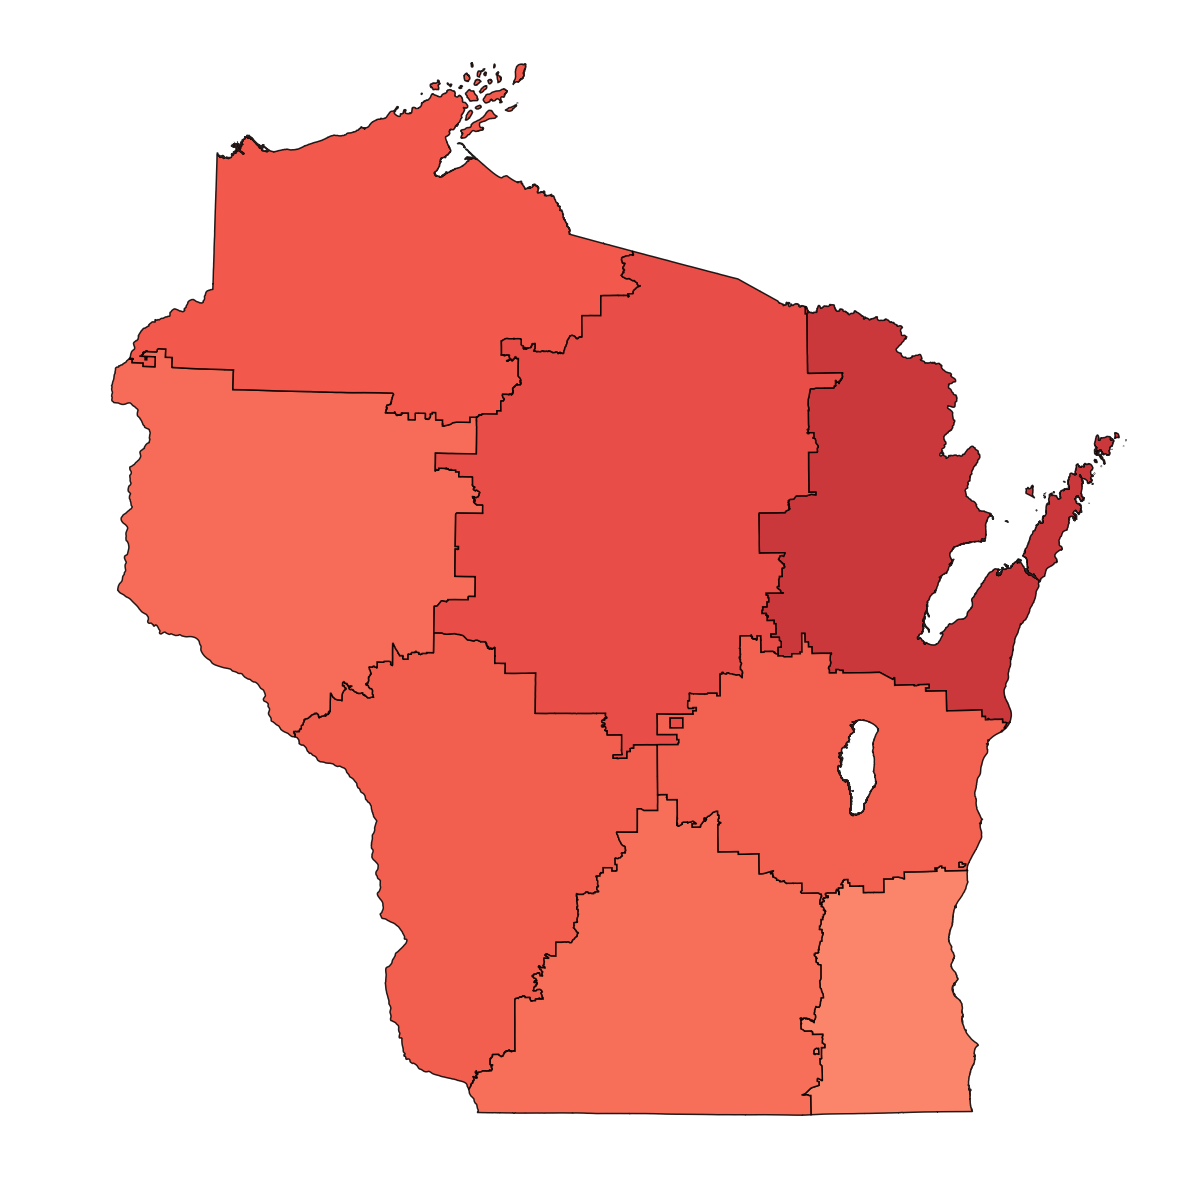

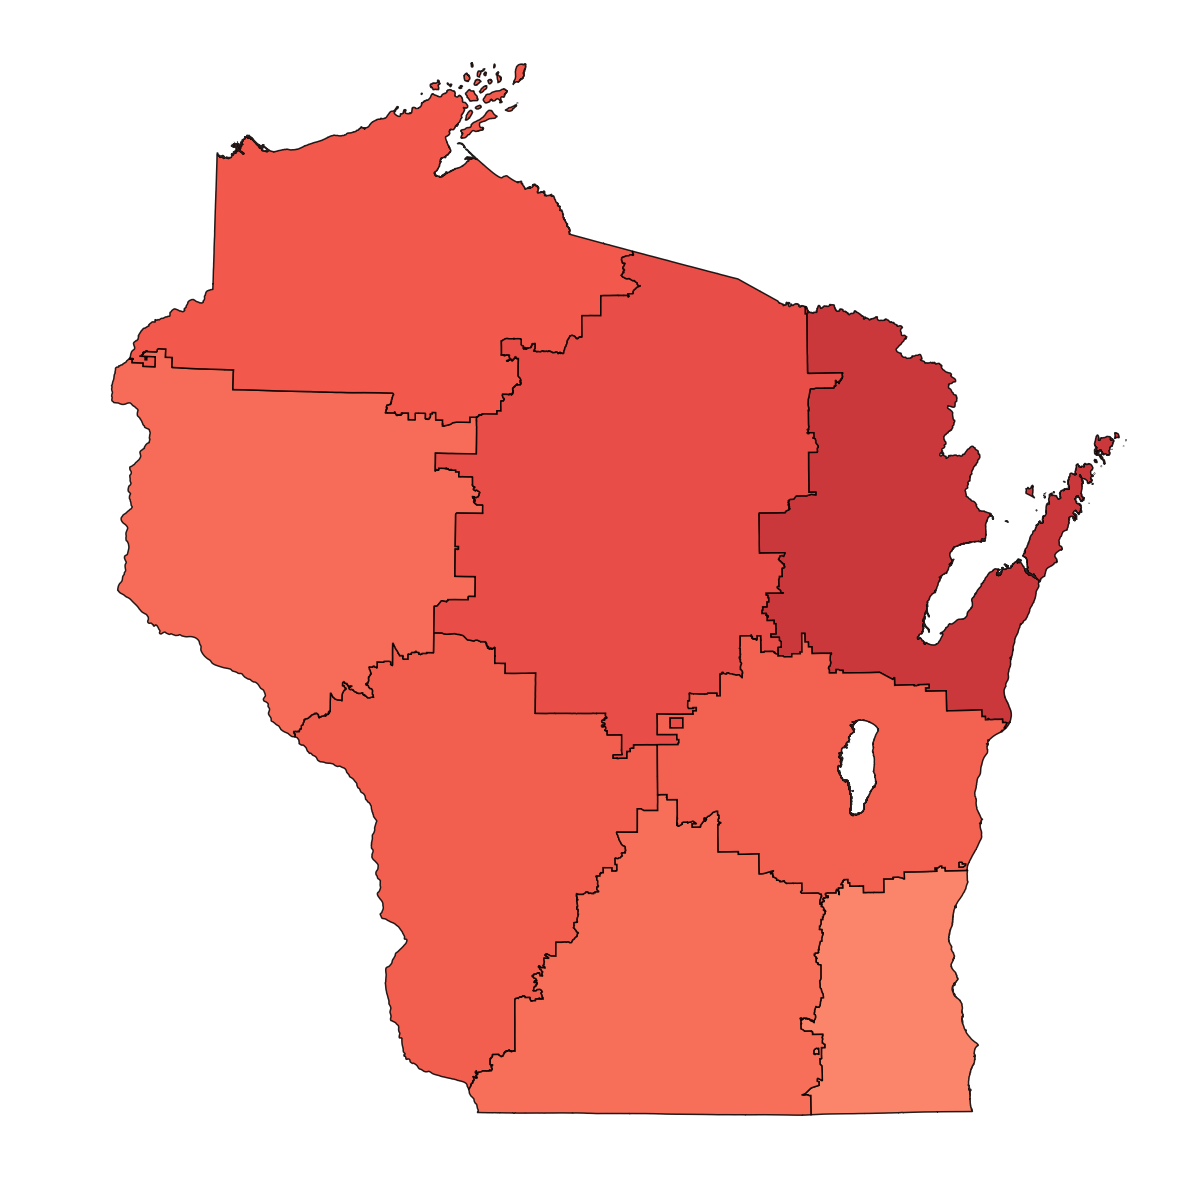

In [21]:
ref_aspect = 1.5
reference = 4*pi*(ref_aspect)/(2*(1+ref_aspect))**2
cmpct_values = [dis['compactness'] for dis in districts]
cmpct_colors = generate_colors(cmpct_values, cm.Reds_r, reference=reference)

plot_shapes(districts, cmpct_colors)

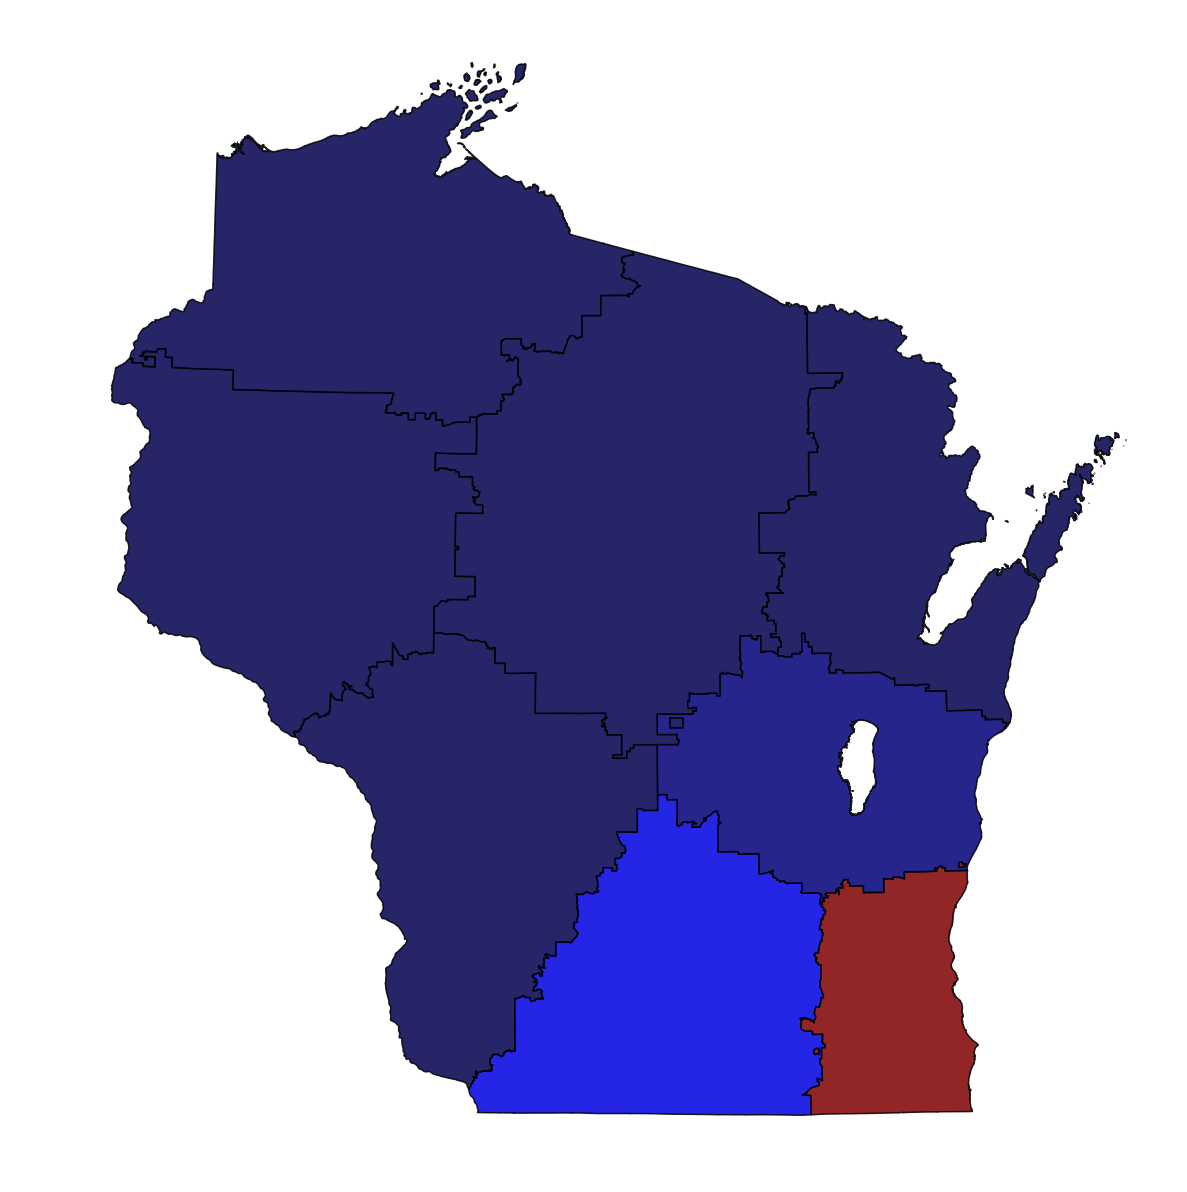

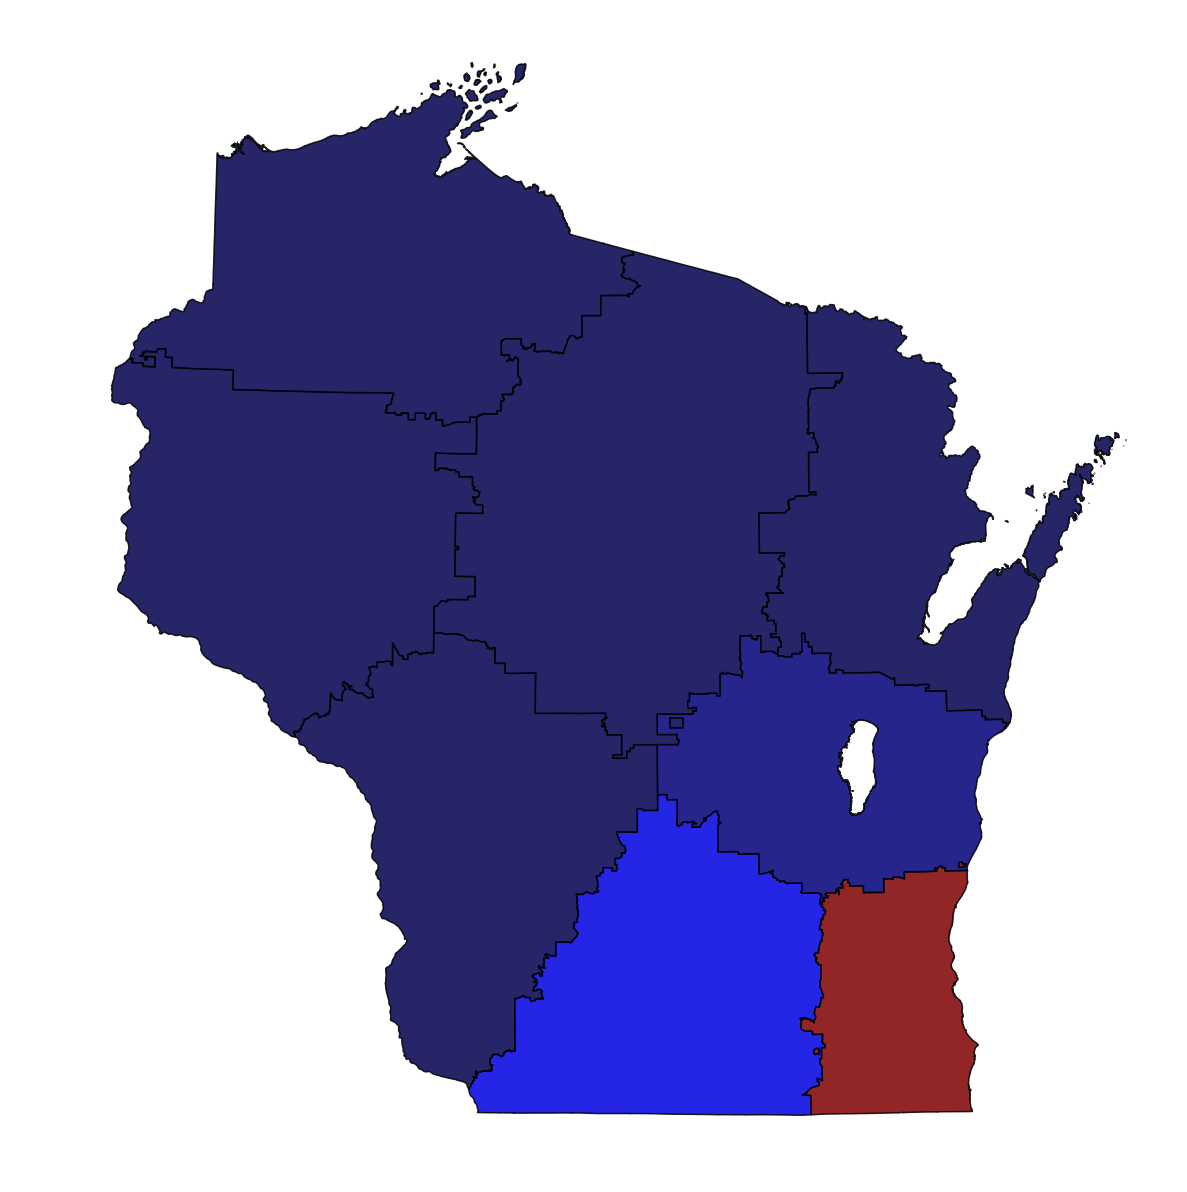

In [23]:
signed_vars = [district['popdiff'] for district in districts]
var_colors = generate_colors(signed_vars, cm.seismic, reference=max(np.abs(signed_vars)))

plot_shapes(districts, var_colors)

In [24]:
with fiona.collection("data/districts/generated/kmeans/kmeans.shp", "r") as source:
    features = [feature for feature in source]
    crs = " ".join("+{}={}".format(key,value) for key, value in source.crs.items())
    
for feature in features:
    feature['geometry'] = mapping(
        shape(feature['geometry']).simplify(4e-3)
    )

In [26]:
my_layer = {
    "type": "FeatureCollection",
    "features": features,
    "crs": {
        "type": "link", 
        "properties": {"href": "kmeans_districts.crs", "type": "proj4"}
    }
}

with open("src/static/geojson/kmeans_districts.json", "w") as f:
    f.write(unicode(json.dumps(my_layer)))
with open("src/static/geojson/kmeans_districts.crs", "w") as f:
    f.write(unicode(crs))

In [103]:
class SameSizeKMeans(object):
    '''K-Means clustering
    
    Parameters
    ----------
    n_clusters : int, optional, default: 8
        The number of clusters to form as well as the number of
        centroids to generate.
    
    weight_tol : float, default: 1e-4
        Fractional tolerance of the 
        
    init_model: KMeans object, default: None
        The initial KMeans model to fit on. Leaving as None
        defaults to KMeans with default parameters except for
        passing the as-specified n_clusters.
        
    save_labels: bool, default: False
        Whether to save labels at each step of the fitting
        process. Setting to True will cause the creation
        
    Attributes
    ----------
    cluster_centers_ : array, [n_clusters, n_features]
        Final coordinates of cluster centers
    
    labels_ :
        Final labels of each point
        
    all_labels_:
        Labels of each point at each step of the fitting
        process. None unless save_labels is set to True.
    
    '''
    
    def __init__(self, n_clusters=8, init_model = None,
                 save_labels=False):
        self.n_clusters = n_clusters
        if init_model is None:
            self.init_model = KMeans(n_clusters=n_clusters)
        else:
            self.init_model = init_model
        self.init_params = self.init_model.get_params()
        self.save_labels = save_labels
        if save_labels:
            self.all_labels_ = []
        else:
            self.all_labels_ = None
        
    def fit(self, X, weights=None, weight_tol=0, order='largest_first'):
        
        self._save_fit_params(X, weights, weight_tol)
        
        for step in range(self.n_clusters):
            # Get temporary labels from a naive KMeans clustering
            # Fit all the data on the first step
            _X = deepcopy(X)
            if step == 0:
                _temp_labels = self._fit_naive_KMeans(_X, step)
            # Fit only the data that hasn't been assigned a new cluster
            elif (step < self.n_clusters - 1):
                # Drop coordinates of points already assigned thier final
                # labels
                _X = _X[self.final_labels == self._init_dummy_label]
                _temp_labels = self._fit_naive_KMeans(_X, step)
            # If last step, assign the leftover points their final label
            else:
                _X = _X[self.final_labels == self._init_dummy_label]
                self.final_labels[self.final_labels == self._init_dummy_label] = 1
                self.final_labels = self.final_labels.astype(np.int)
                break
            
            if order == 'largest_first':
                _coords, _weights = self._find_largest_cluster(_X, _temp_labels)
            elif order == 'smallest_first':
                _coords, _weights, _X, _weights_remainder = (
                    self._find_smallest_cluster(_X, _temp_labels))
                _centroid = np.mean(_coords, axis=0)
                

            # Check if the cluster has the right total weight by comparing it
            # to the ideal cluster weight and the specified weight tolerance.
            # If it doesn't, find the point farthest from (closest to) the
            # center of mass,and throw it out (add it in). Repeat until
            # satisfied.
            while (abs(np.sum(_weights) - self._ideal_cluster_weight)/
                   self._ideal_cluster_weight > self.weight_tol):

                if order == 'largest_first':
                    _coords, _weights = self._drop_farthest(_coords, _weights)
                elif order == 'smallest_first':
                    _coords, _weights, _X, _weights_remainder = self._add_closest(
                        _coords, _weights, _X, _weights_remainder, _centroid)
            
            # Reset temporary labels of the points in the cluster
            _temp_labels = self._reset_labels(
                _temp_labels, _X, _coords, self.n_clusters - step)
            if self.save_labels:
                self.all_labels_.append(_temp_labels)
            
            # Reset final labels of the points left in the cluster
            self.final_labels = self._reset_labels(
                self.final_labels, X, _coords, self.n_clusters - step)

            
    def _save_fit_params(self, X, weights, weight_tol):
        
        self.weight_tol = weight_tol
        self._init_dummy_label = 10*self.n_clusters
        self.final_labels = np.ones(X.shape[0])*self._init_dummy_label
        
        if weights is None:
            self.weights = np.ones(X.shape[0])
        else:
            try:
                assert(weights.shape[0] == X.shape[0])
                self.weights = weights                    
            except AssertionError:
                raise AssertionError('X and weights are not the same length')
        
        self._ideal_cluster_weight = np.sum(weights)/self.n_clusters
        
    
    def _fit_naive_KMeans(self, X, step):
        
        # Setup naive KMeans model
        _temp_params = deepcopy(self.init_params)
        _temp_params['n_clusters'] = self.n_clusters - step
        _temp_model = KMeans(**_temp_params)

        # Get labels from KMeans model, and save them if desired
        _temp_labels = _temp_model.fit_predict(X)
        if self.save_labels:
            self.all_labels_.append(_temp_labels)
            
        return _temp_labels
    
    def _find_largest_cluster(self, X, labels):
        '''Finds the largest cluster'''
        
        # Calculate the weights of each cluster, then determine
        # the largest cluster, along with the coordinates and
        # weights of its points
        _temp_weights = self.weights[self.final_labels == self._init_dummy_label]
        _label_weights = {
            label: np.sum(_temp_weights[labels == label])
            for label in np.unique(labels)
        }
        _largest_cluster = max(_label_weights, key=_label_weights.get)
        _largest_coords = X[labels == _largest_cluster]
        _largest_weights = _temp_weights[labels == _largest_cluster]
        
        return(_largest_coords, _largest_weights)
    
    def _find_smallest_cluster(self, X, labels):
        '''Finds the smallest cluster'''
        
        # Calculate the weights of each cluster, then determine
        # the smallest cluster, along with the coordinates and
        # weights of its points, and the weights of the remainder
        _temp_weights = self.weights[self.final_labels == self._init_dummy_label]
        _label_weights = {
            label: np.sum(_temp_weights[labels == label])
            for label in np.unique(labels)
        }
        _smallest_cluster = min(_label_weights, key=_label_weights.get)
        _smallest_coords = X[labels == _smallest_cluster]
        _smallest_weights = _temp_weights[labels == _smallest_cluster]
        _weights_remainder = _temp_weights[labels != _smallest_cluster]
        _X = X[labels != _smallest_cluster]
        
        return(_smallest_coords, _smallest_weights, _X, _weights_remainder)
    
    def _drop_farthest(self, coords, weights):
            
        center_of_mass = (
            np.sum(weights[:, None]*coords, axis=0)/
            np.sum(weights))[None, :]        
        
        _sqrd_dists = np.sum((coords - center_of_mass)**2, axis=1)
        _farthest_point = np.argmax(_sqrd_dists)
        _mask = (_sqrd_dists != _sqrd_dists[_farthest_point])
        
        _coords = coords[_mask]
        _weights = weights[_mask]
        
        return(_coords, _weights)
    
    def _add_closest(self, coords, weights, X, weights_remainder, centroid):       
        
        _sqrd_dists = np.sum((X - centroid)**2, axis=1)
        _closest_point_ind = np.argmin(_sqrd_dists)
        _closest_point = X[_closest_point_ind,:].reshape((1,2))
        _closest_point_weight = weights_remainder[_closest_point_ind]
        
        _coords = np.vstack((coords, _closest_point))
        _weights = np.append(weights, _closest_point_weight)
        _X = X[_sqrd_dists != _sqrd_dists[_closest_point_ind]]
        _weights_remainder = weights_remainder[
            _sqrd_dists != _sqrd_dists[_closest_point_ind]
        ]
        
        return(_coords, _weights, _X, _weights_remainder)
    
    def _reset_labels(self, init_labels, orig_coords,
                      changed_coords, new_label):
        
        _temp = deepcopy(init_labels)
        _mask = np.logical_and(
            np.in1d(orig_coords[:,0], changed_coords[:,0]),
            np.in1d(orig_coords[:,1], changed_coords[:,1]))
        
        _temp[_mask] = new_label
        
        return _temp.astype(np.int)
    
def drop_coords(array, coords):

    _mask = np.logical(
        np.in1d(array[:,0], coords[:,0]),
        np.in1d(array[:,1], coords[:,1])
    )
        
    return array[_mask]
        
    

In [104]:
sskmeans = SameSizeKMeans(save_labels=True)

In [105]:
sskmeans.fit(coord_array, weights=weight_array, weight_tol=1e-3, order='smallest_first')

In _add_closest
coords: (130, 2), weights: (130,), X: (4345, 2), weights_rem: (4345,)
In _add_closest
coords: (131, 2), weights: (131,), X: (4344, 2), weights_rem: (4344,)
In _add_closest
coords: (132, 2), weights: (132,), X: (4343, 2), weights_rem: (4343,)
In _add_closest
coords: (133, 2), weights: (133,), X: (4342, 2), weights_rem: (4342,)
In _add_closest
coords: (134, 2), weights: (134,), X: (4341, 2), weights_rem: (4341,)
In _add_closest
coords: (135, 2), weights: (135,), X: (4340, 2), weights_rem: (4340,)
In _add_closest
coords: (136, 2), weights: (136,), X: (4339, 2), weights_rem: (4339,)
In _add_closest
coords: (137, 2), weights: (137,), X: (4338, 2), weights_rem: (4338,)
In _add_closest
coords: (138, 2), weights: (138,), X: (4337, 2), weights_rem: (4337,)
In _add_closest
coords: (139, 2), weights: (139,), X: (4336, 2), weights_rem: (4336,)
In _add_closest
coords: (140, 2), weights: (140,), X: (4335, 2), weights_rem: (4335,)
In _add_closest
coords: (141, 2), weights: (141,), X: 

/home/pmende/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:216: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4475 but corresponding boolean dimension is 3907


In _add_closest
coords: (197, 2), weights: (197,), X: (3710, 2), weights_rem: (3710,)
In _add_closest
coords: (198, 2), weights: (198,), X: (3709, 2), weights_rem: (3709,)
In _add_closest
coords: (199, 2), weights: (199,), X: (3708, 2), weights_rem: (3708,)
In _add_closest
coords: (200, 2), weights: (200,), X: (3707, 2), weights_rem: (3707,)
In _add_closest
coords: (201, 2), weights: (201,), X: (3706, 2), weights_rem: (3706,)
In _add_closest
coords: (202, 2), weights: (202,), X: (3705, 2), weights_rem: (3705,)
In _add_closest
coords: (203, 2), weights: (203,), X: (3704, 2), weights_rem: (3704,)
In _add_closest
coords: (204, 2), weights: (204,), X: (3703, 2), weights_rem: (3703,)
In _add_closest
coords: (205, 2), weights: (205,), X: (3702, 2), weights_rem: (3702,)
In _add_closest
coords: (206, 2), weights: (206,), X: (3701, 2), weights_rem: (3701,)
In _add_closest
coords: (207, 2), weights: (207,), X: (3700, 2), weights_rem: (3700,)
In _add_closest
coords: (208, 2), weights: (208,), X: 

/home/pmende/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:216: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3907 but corresponding boolean dimension is 3395


coords: (253, 2), weights: (253,), X: (3142, 2), weights_rem: (3142,)
In _add_closest
coords: (254, 2), weights: (254,), X: (3141, 2), weights_rem: (3141,)
In _add_closest
coords: (255, 2), weights: (255,), X: (3140, 2), weights_rem: (3140,)
In _add_closest
coords: (256, 2), weights: (256,), X: (3139, 2), weights_rem: (3139,)
In _add_closest
coords: (257, 2), weights: (257,), X: (3138, 2), weights_rem: (3138,)
In _add_closest
coords: (258, 2), weights: (258,), X: (3137, 2), weights_rem: (3137,)
In _add_closest
coords: (259, 2), weights: (259,), X: (3136, 2), weights_rem: (3136,)
In _add_closest
coords: (260, 2), weights: (260,), X: (3135, 2), weights_rem: (3135,)
In _add_closest
coords: (261, 2), weights: (261,), X: (3134, 2), weights_rem: (3134,)
In _add_closest
coords: (262, 2), weights: (262,), X: (3133, 2), weights_rem: (3133,)
In _add_closest
coords: (263, 2), weights: (263,), X: (3132, 2), weights_rem: (3132,)
In _add_closest
coords: (264, 2), weights: (264,), X: (3131, 2), weigh

/home/pmende/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:216: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3395 but corresponding boolean dimension is 2844



coords: (307, 2), weights: (307,), X: (2537, 2), weights_rem: (2537,)
In _add_closest
coords: (308, 2), weights: (308,), X: (2536, 2), weights_rem: (2536,)
In _add_closest
coords: (309, 2), weights: (309,), X: (2535, 2), weights_rem: (2535,)
In _add_closest
coords: (310, 2), weights: (310,), X: (2534, 2), weights_rem: (2534,)
In _add_closest
coords: (311, 2), weights: (311,), X: (2533, 2), weights_rem: (2533,)
In _add_closest
coords: (312, 2), weights: (312,), X: (2532, 2), weights_rem: (2532,)
In _add_closest
coords: (313, 2), weights: (313,), X: (2531, 2), weights_rem: (2531,)
In _add_closest
coords: (314, 2), weights: (314,), X: (2530, 2), weights_rem: (2530,)
In _add_closest
coords: (315, 2), weights: (315,), X: (2529, 2), weights_rem: (2529,)
In _add_closest
coords: (316, 2), weights: (316,), X: (2528, 2), weights_rem: (2528,)
In _add_closest
coords: (317, 2), weights: (317,), X: (2527, 2), weights_rem: (2527,)
In _add_closest
coords: (318, 2), weights: (318,), X: (2526, 2), weig

/home/pmende/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:216: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2844 but corresponding boolean dimension is 2303


In _add_closest
coords: (295, 2), weights: (295,), X: (2008, 2), weights_rem: (2008,)
In _add_closest
coords: (296, 2), weights: (296,), X: (2007, 2), weights_rem: (2007,)
In _add_closest
coords: (297, 2), weights: (297,), X: (2006, 2), weights_rem: (2006,)
In _add_closest
coords: (298, 2), weights: (298,), X: (2005, 2), weights_rem: (2005,)
In _add_closest
coords: (299, 2), weights: (299,), X: (2004, 2), weights_rem: (2004,)
In _add_closest
coords: (300, 2), weights: (300,), X: (2003, 2), weights_rem: (2003,)
In _add_closest
coords: (301, 2), weights: (301,), X: (2002, 2), weights_rem: (2002,)
In _add_closest
coords: (302, 2), weights: (302,), X: (2001, 2), weights_rem: (2001,)
In _add_closest
coords: (303, 2), weights: (303,), X: (2000, 2), weights_rem: (2000,)
In _add_closest
coords: (304, 2), weights: (304,), X: (1999, 2), weights_rem: (1999,)
In _add_closest
coords: (305, 2), weights: (305,), X: (1998, 2), weights_rem: (1998,)
In _add_closest
coords: (306, 2), weights: (306,), X: 

/home/pmende/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:216: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2303 but corresponding boolean dimension is 1759


In _add_closest
coords: (263, 2), weights: (263,), X: (1496, 2), weights_rem: (1496,)
In _add_closest
coords: (264, 2), weights: (264,), X: (1495, 2), weights_rem: (1495,)
In _add_closest
coords: (265, 2), weights: (265,), X: (1494, 2), weights_rem: (1494,)
In _add_closest
coords: (266, 2), weights: (266,), X: (1493, 2), weights_rem: (1493,)
In _add_closest
coords: (267, 2), weights: (267,), X: (1492, 2), weights_rem: (1492,)
In _add_closest
coords: (268, 2), weights: (268,), X: (1491, 2), weights_rem: (1491,)
In _add_closest
coords: (269, 2), weights: (269,), X: (1490, 2), weights_rem: (1490,)
In _add_closest
coords: (270, 2), weights: (270,), X: (1489, 2), weights_rem: (1489,)
In _add_closest
coords: (271, 2), weights: (271,), X: (1488, 2), weights_rem: (1488,)
In _add_closest
coords: (272, 2), weights: (272,), X: (1487, 2), weights_rem: (1487,)
In _add_closest
coords: (273, 2), weights: (273,), X: (1486, 2), weights_rem: (1486,)
In _add_closest
coords: (274, 2), weights: (274,), X: 

/home/pmende/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:216: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1759 but corresponding boolean dimension is 1184
/home/pmende/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:216: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1184 but corresponding boolean dimension is 662


In [394]:
labels = sskmeans.final_labels
for label, block in zip(labels, blocks):
    block['label'] = int(label)

In [395]:
new_districts = [{} for label in np.unique(labels)]
for i, label in enumerate(np.unique(labels)):
    new_districts[i]['shape'] = cascaded_union(
        [block['shape'] for block in blocks if block['label'] == label]
    )
    
    new_districts[i]['untransformed'] = cascaded_union([
        block['untransformed']
        for block in blocks
        if block['label'] == label
    ])

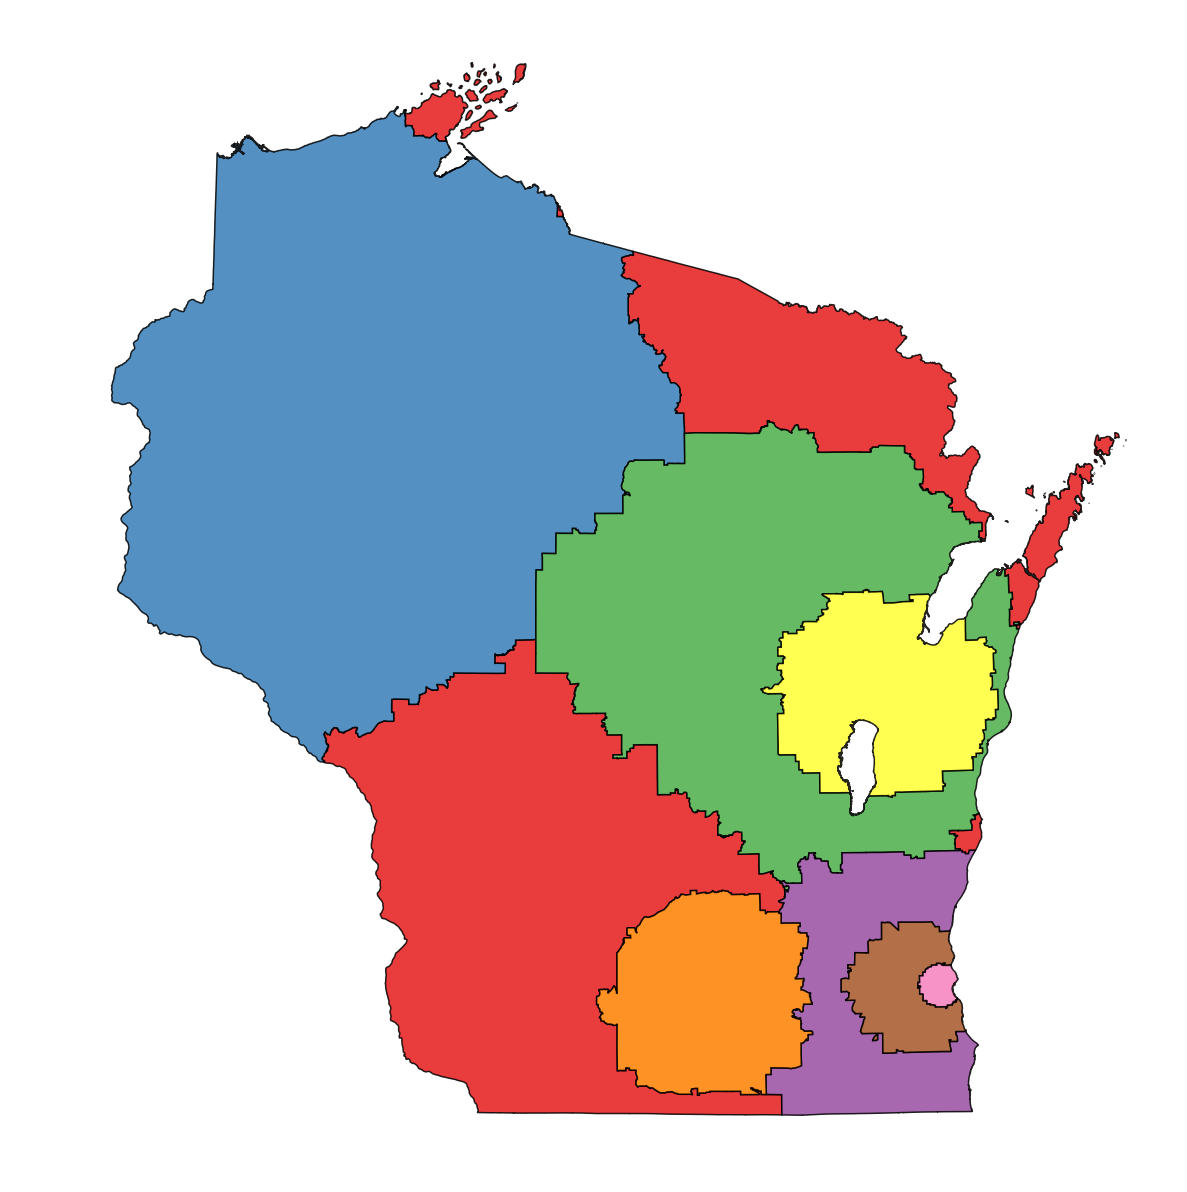

In [386]:
hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf',
    '#ffffff'
]
district_colors = [to_rgb(color) for color in hex_colors]

kmeans_file = 'images/samesize_kmeans_test_largest_only.png'
plot_shapes(new_districts, district_colors, fig_file=kmeans_file)

In [218]:
np.sum([block['poptot'] for block in blocks if block['label']==7])

710856

In [1]:
a = np.array([[1,1], [2,2]])
for thing in a:
    print(thing)

NameError: name 'np' is not defined